# Matérn kernel on SPD 

This notebooks illustrates Matérn kernel on a space of Symmetric Positive-Definite Matrices.

We use numpy for the computations and matplotlib for vizualization.

## Table of contents
[Introduction](#intro)

[Kernel instantiation](#instantiate)

[Plot kernel values along a geodesic](#geodesic)

[Rejection sampling feature map/kernel](#rs)


## Introduction <a name="intro"></a>

In [1]:
import geomstats.visualization as visualization
import matplotlib.pyplot as plt
import numpy as np

INFO: Using numpy backend


We employ the kernel defined by the _random phase features_. A complete mathematical treatise can be found in [1]. For the purposes of this notebook, it suffices to say that on noncompact symmetric spaces (of which the SPD space is a fine specimen), the kernel is defined in terms of an intractable integral over a probability density (called the *spectral density*). To approximate the integral, we use Monte Carlo sampling from the spectral density.

This is in contrast to _compact_ spaces (which we call `DiscreteSpectrumSpace`s), where the kernel is a sum of a _series_, that can be approximated via truncation.

On the SPD space, there are several methods for sampling from the spectral density. We will investigate them in this notebook.

For practical purposes, we just have to define a number of _random phases_ (the more we define, the better the approximation and the more computation required), specify a feature map, and pass it to the `MaternFeatureMapKernel`. The kernel requires a `key` to instantiate randomness in the _random phases_, and is a **deterministic** function.

In [2]:
from geometric_kernels.kernels.geometric_kernels import MaternFeatureMapKernel
from geometric_kernels.kernels.feature_maps import random_phase_feature_map_noncompact, rejection_sampling_feature_map_spd
from geometric_kernels.spaces.spd import SymmetricPositiveDefiniteMatrices

## Instantiate space and kernel <a name="instantiation"></a>



In the numpy world, the `key` is the `np.random.RandomState`:

In [3]:
_num_random_phases = 5_000

In [4]:
key = np.random.RandomState(seed=1234)  #

In [5]:
spd = SymmetricPositiveDefiniteMatrices(n=2)
feature_map = random_phase_feature_map_noncompact(spd, num_random_phases=_num_random_phases)
kernel = MaternFeatureMapKernel(spd, feature_map, key)

params, state = kernel.init_params_and_state()
params["nu"] = np.inf
params["lengthscale"] = 0.1

## Plot kernel values along a geodesic <a name="geodesic"></a>

Let's plot kernel values `K(x, y)` where `y` runs the geodesic between `base` and `end_point`.

In [6]:
base = np.eye(2)
end_point = np.r_[1.0, 0.5, 0.5, 1.0].reshape(2,2)

geodesic = spd.metric.geodesic(initial_point=base, end_point=end_point)
x1 = geodesic(np.linspace(0.0, 1.0, 30))
x2 = x1[0, None]

distances = spd.metric.dist(x1, x2)

In [7]:
kernel_vals = kernel.K(params, state, x1, x2)

Text(0, 0.5, 'K')

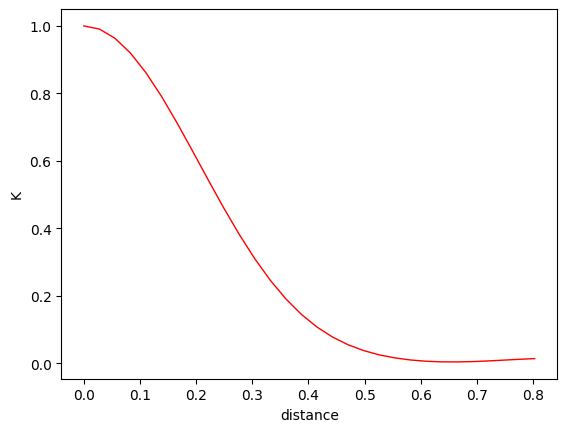

In [8]:
plt.plot(distances, kernel_vals, color="red", linewidth=1)
plt.xlabel('distance')
plt.ylabel('K')

## Rejection sampling feature map/kernel <a name="rs"></a>

Let's investigate the behaviour of another feature map defined on the SPD space. The feature map uses a specific form that the spectral density has in the SPD space, and samples from the spectral density using rejection sampling.

In the limit, when `_num_random_phases` tends to infinity, both feature maps give the same kernel. In order to contrast the two, we call the previous one "naive sampling based".

The math can be found in [1].

In [9]:
feature_map_rs = rejection_sampling_feature_map_spd(spd, num_random_phases=_num_random_phases)

In [10]:
kernel_rs = MaternFeatureMapKernel(spd, feature_map_rs, key)

In [11]:
kernel_vals_rs = kernel_rs.K(params, state, x1, x2)

Let's compare the two feature maps. They should be pretty close.

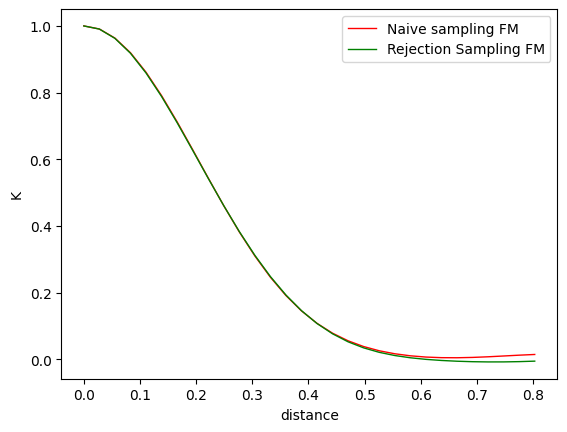

In [12]:
plt.plot(distances, kernel_vals, color="red", linewidth=1, label='Naive sampling FM')
plt.plot(distances, kernel_vals_rs, color="green", linewidth=1, label='Rejection Sampling FM')
plt.xlabel('distance')
plt.ylabel('K')
plt.legend()

Let's plot the convergence of the naive and rejection-sampling based approaches, as we construct more and more feature maps.

In [13]:
_num_phases = np.linspace(10, 3000, 20).astype(int)

In [14]:
naive_feature_maps = [random_phase_feature_map_noncompact(spd, num_random_phases=n) for n in _num_phases]
rs_feature_maps = [rejection_sampling_feature_map_spd(spd, num_random_phases=n) for n in _num_phases]

In [15]:
naive_kernels = [MaternFeatureMapKernel(spd, fm, key) for fm in naive_feature_maps]
rs_kernels = [MaternFeatureMapKernel(spd, fm, key) for fm in rs_feature_maps]


Let's evaluate the kernels on the same set of points, effectively getting two sequences of vectors.

To evaluate the convergence, we are going to compute the $L_2$-distances of the subsequent vectors.

In [16]:
naive_kernels_vals = [k.K(params, state, x1, x2) for k in naive_kernels]
rs_kernels_vals = [k.K(params, state, x1, x2) for k in rs_kernels]

In [17]:
naive_diffs = np.diff(naive_kernels_vals, axis=0)
rs_diffs = np.diff(rs_kernels_vals, axis=0)

naive_l2s = np.sqrt(np.sum(naive_diffs**2, axis=1))
rs_l2s = np.sqrt(np.sum(rs_diffs**2, axis=1))

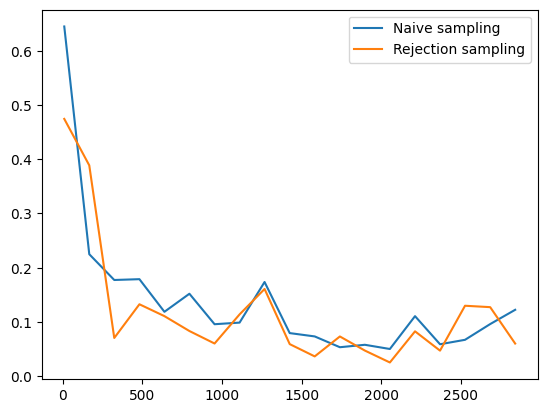

In [18]:
plt.plot(_num_phases[:-1], naive_l2s.ravel(), label='Naive sampling')
plt.plot(_num_phases[:-1], rs_l2s.ravel(), label='Rejection sampling')
plt.legend()

The rejection sampling based kernels show a better rate of convergence.

To illustrate this further, plot the kernel values for all the kernels we have computed. 

The rejection sampling based kernels values are more concentrated around the true kernel, 
whereas the naive sampling based kernels show higher distortion.

Text(0, 0.5, 'K')

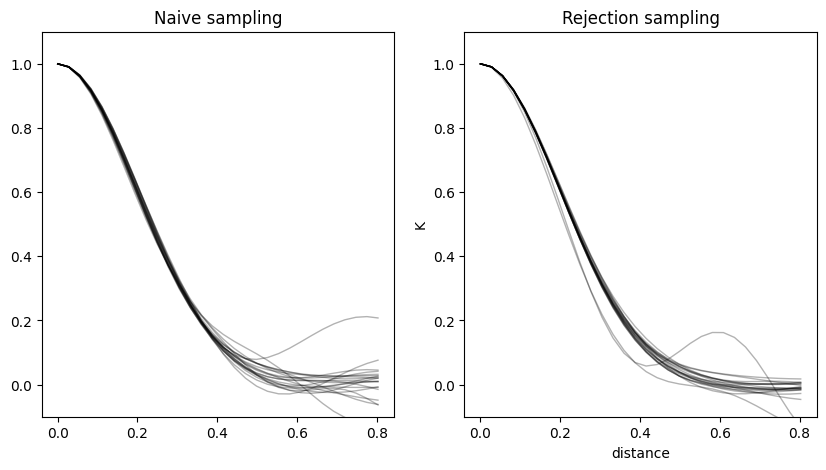

In [19]:
plt.figure(figsize=(10, 5))
for nf, naive_v, rs_v in zip(_num_phases, naive_kernels_vals, rs_kernels_vals):
    plt.subplot(121)
    plt.plot(distances, naive_v, linewidth=1, c='k', alpha=0.3)
    plt.subplot(122)
    plt.plot(distances, rs_v, linewidth=1, c='k', alpha=0.3)

plt.subplot(121)
plt.title('Naive sampling')
plt.ylim(-0.1, 1.1)
plt.subplot(122)
plt.title('Rejection sampling')
plt.ylim(-0.1, 1.1)
plt.xlabel('distance')
plt.ylabel('K')

That said, the rejection sampling might require more compute. It is up to a practioner to decide what type of kernel works best for the task at hand.